/var/folders/y5/yhh2lj4d5pqfmj880n0dd8180000gn/T/ipykernel_77018/2081154335.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('turbo', len(psi_degs))
/var/folders/y5/yhh2lj4d5pqfmj880n0dd8180000gn/T/ipykernel_77018/2081154335.py:106: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

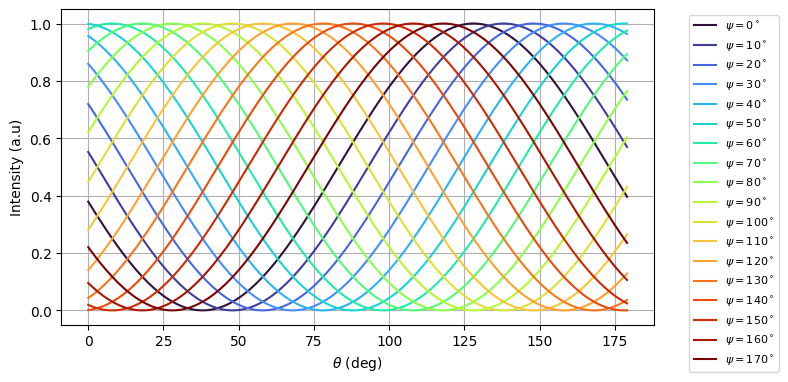

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def read_data(path):
    df = pd.read_csv(path, comment='#')
    #df = pd.read_csv('../dat/GREEN/808nm_calib.csv', comment='#')
    # err data angles
    
    angle_deg = df.iloc[:, 0].values
    angle_rad = np.deg2rad(angle_deg)  # 0 to pi
    
    intensities = df.iloc[:, 1:].values
    intensities_rad = intensities.T

    return angle_rad, intensities_rad

# function for HWP
def D_HWP(theta, psi, E_x, E_y):
    cth = np.cos(theta)
    sth = np.sin(theta)
    c2p = np.cos(2*psi)
    s2p = np.sin(2*psi)
    cth2 = cth**2
    sth2 = sth**2
    cth_sth = cth*sth
    
    E_out_x = (cth2 * c2p + cth_sth * s2p) * E_x + (cth2 * s2p - cth_sth * c2p) * E_y
    E_out_y = (cth_sth * c2p + sth2 * s2p) * E_x + (cth_sth * s2p - sth2 * c2p) * E_y
    
    return np.array([E_out_x, E_out_y])

# function for QWP
def D_QWP(theta, psi, E_x, E_y):
    cth = np.cos(theta)
    sth = np.sin(theta)
    c2p = np.cos(2*psi)
    s2p = np.sin(2*psi)
    cth2 = cth**2
    sth2 = sth**2
    cth_sth = cth*sth
    cpsi = np.cos(psi)
    spsi = np.sin(psi)
    i = 1j

    R_psi = np.array([[cpsi, -spsi], [spsi, cpsi]])
    R_minus_psi = np.array([[cpsi, spsi], [-spsi, cpsi]])
    QWP_matrix = np.array([[1, 0], [0, 1j]])

    cth = np.cos(theta)
    sth = np.sin(theta)
    R_theta = np.array([[cth, -sth], [sth, cth]])
    R_minus_theta = np.array([[cth, sth], [-sth, cth]])
    P_matrix = np.array([[1, 0], [0, 0]])
    
    operator = R_minus_theta @ P_matrix @ R_theta @ R_minus_psi @ QWP_matrix @ R_psi
    
    E_in = np.array([E_x, E_y])
    E_out = operator @ E_in
    return E_out

def dorun(): 
    plt.figure(figsize=(10,6))
    # plot theoretical output intensity curves. delta is some real physical phase difference. used to fine tune output.
    Fnc = D_HWP
    PsiMax = 170
    LaserRotation = 0
    delta = 0
    ThetaOffsetDeg = 52
    scX = 1.0
    scY = 1.0
    
    
    phi = np.deg2rad(LaserRotation)
    E_x = np.cos(phi)
    E_y = np.exp(1j * np.deg2rad(delta)) * np.sin(phi)
    fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
    theta_deg = np.linspace(0, 180, 181)
    theta_rad = np.deg2rad(theta_deg)
    psi_degs = np.arange(0, PsiMax + 1, 10)
    cmap = plt.cm.get_cmap('turbo', len(psi_degs))
    exp_x, exp_y = read_data('/users/lucas/desktop/physics/year 3/project 1/dat/wp/r_180.csv')
    exp_y = exp_y / np.nanmax(exp_y)
    exp_x = exp_x * 180 / 3.14159265
    i = 0
    ymax = 0
    for psi_deg in psi_degs:
        psi_rad = np.deg2rad(psi_deg)
        intensities = []
        for t in theta_rad:
            E_out = Fnc(t, psi_rad * 0.5, E_x, E_y)
            intensity = np.abs(E_out[0])**2 + np.abs(E_out[1])**2
            intensities.append(intensity)
        theta_deg_shifted = (theta_deg - ThetaOffsetDeg) % 180
        sorted_idx = np.argsort(theta_deg_shifted)
        xs = theta_deg_shifted[sorted_idx]
        ys = np.array(intensities)[sorted_idx] * scY
        ymax = max(ymax, np.nanmax(ys))
        ax.plot(xs * scX, ys, label=f'$\psi={psi_deg}^\circ$', color=cmap(i))
        i = i + 1

    plt.xlabel('$\\theta$ (deg)')
    plt.ylabel('Intensity (a.u)')
    plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

dorun()